In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats


from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, StratifiedKFold

from tqdm.notebook import tqdm

In [29]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

# UniCredit 2

# EDA

- Множества признаков трейна и теста совпадают

In [3]:
train.shape, test.shape

((900000, 33), (700000, 32))

In [4]:
set(train.columns) - set(test.columns)

{'target'}

In [5]:
train.head()

,id,f_00,f_01,f_02,f_03,f_04,f_05,f_06,f_07,f_08,...,f_22,f_23,f_24,f_25,f_26,f_27,f_28,f_29,f_30,target
0,0,-1.373246,0.238887,-0.243376,0.567405,-0.647715,0.839326,0.113133,1,5,...,-2.540739,0.766952,-2.730628,-0.208177,1.363402,ABABDADBAB,67.609153,0,0,0
1,1,1.697021,-1.710322,-2.230332,-0.545661,1.113173,-1.552175,0.447825,1,3,...,2.278315,-0.633658,-1.217077,-3.782194,-0.058316,ACACCADCEB,377.096415,0,0,1
2,2,1.681726,0.616746,-1.027689,0.810492,-0.609086,0.113965,-0.708660,1,0,...,-1.385775,-0.520558,-0.009121,2.788536,-3.703488,AAAEABCKAD,-195.599702,0,2,1
3,3,-0.118172,-0.587835,-0.804638,2.086822,0.371005,-0.128831,-0.282575,3,2,...,0.572594,-1.653213,1.686035,-2.533098,-0.608601,BDBBAACBCB,210.826205,0,0,1
4,4,1.148481,-0.176567,-0.664871,-1.101343,0.467875,0.500117,0.407515,3,3,...,-3.912929,-1.430366,2.127649,-3.306784,4.371371,BDBCBBCHFE,-217.211798,0,1,1


- Замечаем признак f_27, он точно категориальный, так как его значения какие-то строковые последовательности
- Категориальными также могут оказаться целочисленные признаки, но это неизвестно
- NAN'ов нет

In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 900000 entries, 0 to 899999
Data columns (total 33 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   id      900000 non-null  int64  
 1   f_00    900000 non-null  float64
 2   f_01    900000 non-null  float64
 3   f_02    900000 non-null  float64
 4   f_03    900000 non-null  float64
 5   f_04    900000 non-null  float64
 6   f_05    900000 non-null  float64
 7   f_06    900000 non-null  float64
 8   f_07    900000 non-null  int64  
 9   f_08    900000 non-null  int64  
 10  f_09    900000 non-null  int64  
 11  f_10    900000 non-null  int64  
 12  f_11    900000 non-null  int64  
 13  f_12    900000 non-null  int64  
 14  f_13    900000 non-null  int64  
 15  f_14    900000 non-null  int64  
 16  f_15    900000 non-null  int64  
 17  f_16    900000 non-null  int64  
 18  f_17    900000 non-null  int64  
 19  f_18    900000 non-null  int64  
 20  f_19    900000 non-null  float64
 21  f_20    90

- У категориального признака очень большое множество значений. После OHE размерность так вырастет, что для продуктивного обучения модели данных может быть мало. 741 000 признаков и 900 000 строк

In [7]:
len(train.f_27.unique())

741354

- Дизбаланса классов нет

In [8]:
train.target.value_counts(normalize=True)

0    0.513512
1    0.486488
Name: target, dtype: float64

- значения `max` сильно больше значений `75%` кваритиля, что может говорить о выбросах
- `mean` и `50% квартиль` не сильно отличаются, что может говорить о симметрии распределений относительно среднего 

In [30]:
train.describe()

,id,f_00,f_01,f_02,f_03,f_04,f_05,f_06,f_07,f_08,...,f_21,f_22,f_23,f_24,f_25,f_26,f_28,f_29,f_30,target
count,900000.000000,900000.000000,900000.000000,900000.000000,900000.000000,900000.000000,900000.000000,900000.000000,900000.000000,900000.000000,...,900000.000000,900000.000000,900000.000000,900000.000000,900000.000000,900000.000000,900000.000000,900000.000000,900000.000000,900000.000000
mean,449999.500000,-0.000286,0.001165,0.001174,-0.001368,-0.000571,0.000284,-0.000709,2.031460,2.057998,...,-0.156307,-0.009273,-0.369459,-0.342738,0.176549,0.357591,-0.380876,0.345661,1.002654,0.486488
std,259807.765474,0.998888,0.999193,1.000514,1.000175,1.000167,0.999875,0.999942,1.656172,1.590955,...,2.484706,2.450797,2.453405,2.386941,2.416959,2.476020,238.773054,0.475584,0.818989,0.499818
min,0.000000,-4.599856,-4.682199,-4.642676,-4.658816,-4.748501,-4.750214,-4.842919,0.000000,0.000000,...,-13.310146,-11.853530,-12.301097,-11.416189,-11.918306,-14.300577,-1229.753052,0.000000,0.000000,0.000000
25%,224999.750000,-0.675490,-0.675162,-0.674369,-0.676114,-0.675909,-0.673437,-0.674876,1.000000,1.000000,...,-1.820063,-1.645585,-2.019739,-1.955956,-1.440424,-1.261598,-159.427418,0.000000,0.000000,0.000000
50%,449999.500000,0.001144,0.002014,0.002218,-0.002227,-0.001662,-0.000438,-0.001492,2.000000,2.000000,...,-0.152668,0.030850,-0.390966,-0.340746,0.160912,0.404212,-0.519808,0.000000,1.000000,0.000000
75%,674999.250000,0.674337,0.675021,0.677505,0.672544,0.673789,0.675028,0.674749,3.000000,3.000000,...,1.507071,1.661676,1.255408,1.266673,1.795928,2.028219,158.987357,1.000000,2.000000,1.000000
max,899999.000000,4.749301,4.815699,4.961982,4.454920,4.948983,4.971881,4.822668,15.000000,16.000000,...,14.455426,11.344080,12.247100,12.389844,12.529179,12.913041,1229.562577,1.000000,2.000000,1.000000


- Избавимся от выбросов (через чур маленьких и больших значенией) лежащих за пределами `Q1 - 3IQR` и `Q3 + 3IQR`

In [10]:
def boxplot_clear(data, column, x=3):
    data_to_clear = data

    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    first_border = Q1 - x*IQR
    second_border = Q3 + x*IQR
    cleared_data = data_to_clear[(data_to_clear[column] >= first_border) & (data_to_clear[column] <= second_border)] 
    
    # fig,(ax1,ax2)=plt.subplots(1,2, figsize=(8,4))
    # fig.suptitle(column)
    # sns.boxplot(x = data[column],ax=ax1)
    # sns.boxplot(x = cleared_data[column],ax=ax2)
    # ax1.set_title('BEFORE CLEAR')
    # ax2.set_title('AFTER CLEAR')
    # plt.show()
    
    return cleared_data

In [11]:
meh = set(['id','f_27','target'])

In [12]:
columns_ = set(train.columns) - meh
n=train.shape[0]

for column in columns_:
    train = boxplot_clear(train,column)
print(f"Избавились от {n-train.shape[0]} строк")

Избавились от 3924 строк


- Проверим гипотезу о нормальности распределений признаков

In [13]:
for column in columns_:
    t,pvalue = stats.kstest(train[column], 'norm')
    if pvalue>0.05:
        print(f'{column} может быть распредленно нормально')
    else:
        print(f'{column} не распредленно нормально')

f_30 не распредленно нормально
f_18 не распредленно нормально
f_15 не распредленно нормально
f_08 не распредленно нормально
f_24 не распредленно нормально
f_01 может быть распредленно нормально
f_22 не распредленно нормально
f_28 не распредленно нормально
f_13 не распредленно нормально
f_25 не распредленно нормально
f_10 не распредленно нормально
f_00 может быть распредленно нормально
f_23 не распредленно нормально
f_09 не распредленно нормально
f_26 не распредленно нормально
f_19 не распредленно нормально
f_02 может быть распредленно нормально
f_14 не распредленно нормально
f_21 не распредленно нормально
f_06 может быть распредленно нормально
f_17 не распредленно нормально
f_05 может быть распредленно нормально
f_16 не распредленно нормально
f_07 не распредленно нормально
f_12 не распредленно нормально
f_20 не распредленно нормально
f_29 не распредленно нормально
f_04 может быть распредленно нормально
f_11 не распредленно нормально
f_03 может быть распредленно нормально


- Насколько коррелированы признаки между собой (мега скоррелированных признаков нет)

In [14]:
corr=train.corr()

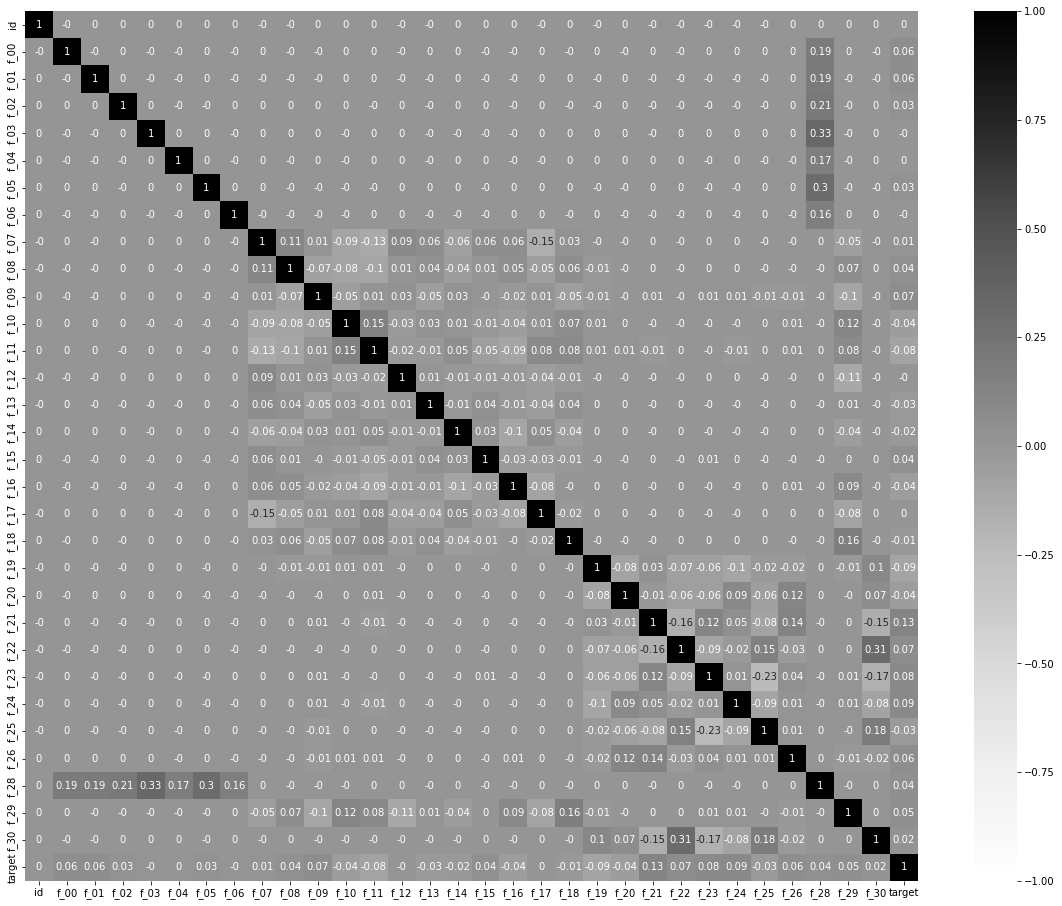

In [15]:
plt.figure(figsize=(20, 16))
sns.heatmap(np.around(corr, decimals = 2), vmin=-1, vmax=1, cmap='Greys', annot=True)
plt.show()

# Gini index

In [16]:
def Gini_coef(feature):
    '''feature - pd series значения признака'''
    feature = feature.sort_values(ignore_index=True)
    '''Если есть отрицательные значения'''
    if min(feature)<0:
        return 'Не определен' 
        #feature += abs(min(feature))
        #feature = feature[feature>0]
        #feature[feature<0] = 0
    n=len(feature)
    x_cum = pd.Series(np.arange(1,n+1)/n)
    x_cum_1 = x_cum.shift().fillna(0)
    feature_cumsum = np.cumsum(feature)/sum(feature)
    feature_cumsum_1 = feature_cumsum.shift().fillna(0)
    gini = 1 - np.sum((x_cum - x_cum_1)*(feature_cumsum + feature_cumsum_1))
    return gini

По поводу индекса джини. Тут встречаются признаки, которые могут принимать отрицательные значения, поэтому просто вычислить индекс джини (target vs feature) не получится, так как кривая Лоренца может уйти в отрицательную область по оси Оу (так как кумулятивная сумма отрицательная).

![Кривая Лоренца](Lorenc.png)

Если А>С то индекс Джини будет больше единицы. Теряется его интерпретируемость (не только из-за того, что G>1 но и из-за самой возможности выхода кривой ниже нуля).

Можно поробовать решить несколькими способами, описанными тут: [The Gini coefficient and the case of negative values](http://siba-ese.unisalento.it/index.php/ejasa/article/view/19223#:~:text=When%20negative%20values%20are%20included,maximum%20inside%20each%20particular%20situation)

Например:
- **Замена отрицательных значений нулями**. Мне не нравится данный способ, так как в некоторых признаках бОльшая часть значений отрицательная, что даже кумулятивная сумма получается отрицательной, заменив их все нулями мы сделаем очень большую "несправедливость" в доле кумулятивной суммы признака приходящуюся на долю наблюдений, из-за чего Gini будет большим. Результаты при использованнии этого способа: min(G)=0.7019, max(G)=0.7504, mean(G) = 0.7107
- **Отброс отрицательных значений**. Результаты при использовании этого способа: min(G)=0.9999, max(G)=1, mean(G) = 0.99995
- **Увеличить все значения на константу, чтобы все значения стали неотрицательными**. Результаты при использовании этого способа: min(G)=0.1204, max(G)=0.1273, mean(G) = 0.1211

В зависимости от способа индексы джини сильно отличаются, я не буду рисковать и для признаков с отрицательными значениями скажу, что индекс не определен

# WoE binning

In [17]:
from optbinning import OptimalBinning, BinningProcess

In [18]:
def feature_informatives(data, target_feature, features_for_check, n=10):
    '''
    data - данные
    target_feature - название целевой признака
    features_for_check - массив названий признаков для проверки
    n - кол-во строк в возвращаемом датафрейме
    
    Функция возвращает датафрейм из n признаков с наибольшим IV\
    '''
    
    columns=['Признак','IV','Интерпретация IV','Gini']
    lst=[]
    
    y=data[target_feature]
    x=data[features_for_check]
    optb_proc = BinningProcess(variable_names=features_for_check, n_jobs=-1).fit(x, y)
    for feature in tqdm(features_for_check):
        optb_table = optb_proc.get_binned_variable(feature).binning_table.build()
        IV = optb_table.loc['Totals','IV']
        Gini = Gini_coef(x[feature])
        if IV<0.02:
            intpr = 'Бесполезен для предсказаний'
        elif IV<0.1:
            intpr = 'Слабая предсказательная сила'
        elif IV<0.3:
            intpr = 'Средняя предсказательная сила'
        elif IV<0.5:
            intpr = 'Сильная предсказательная сила'
        else:
            intpr = 'Подозрительно хорош'
        lst.append([feature, IV, intpr, Gini])
    df = pd.DataFrame(columns=columns, data=lst)
    return df.sort_values(by='IV', ascending=False).head(n)

In [19]:
res = feature_informatives(train, 'target' ,list(columns_))

  0%|          | 0/30 [00:00<?, ?it/s]

In [20]:
res

,Признак,IV,Интерпретация IV,Gini
18,f_21,0.084819,Слабая предсказательная сила,Не определен
14,f_26,0.047056,Слабая предсказательная сила,Не определен
12,f_23,0.046339,Слабая предсказательная сила,Не определен
7,f_28,0.035075,Слабая предсказательная сила,Не определен
15,f_19,0.034324,Слабая предсказательная сила,Не определен
4,f_24,0.032960,Слабая предсказательная сила,Не определен
28,f_11,0.025675,Слабая предсказательная сила,0.458481
6,f_22,0.023734,Слабая предсказательная сила,Не определен
3,f_08,0.019338,Бесполезен для предсказаний,0.418074
13,f_09,0.017465,Бесполезен для предсказаний,0.378438


# UniCredit 3

- Категориальный признак f_27 использоваться не будет, потому что он слишком богатый для моего компьютера :/ 
- Реализуем жадный алгоритм отбора признаков по GINI

In [21]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, StratifiedKFold

In [22]:
target = train.target
train = train.drop(columns=['id','target','f_27'])

In [23]:
def Gini_selection(model, data, target, epsilon = 0.01):
    '''
    model - модель по которой будет считать cross_val_score
    data - данные
    target - целевая переменная
    epsilon - минимальный прирост в gini который должен быть с добавлением нового признака
    
    return:
    Список признаков, которые дали наибольший средний джини
    Значение джини
    '''
    all_features = data.columns
    highest_gini_features_list = []
    highest_gini = 0
    while True:
        features_list = []
        gini_for_features_list = 0
        for feature in set(all_features) - set(highest_gini_features_list):
            current_features = highest_gini_features_list+[feature]
            ginies = 2 * cross_val_score(estimator=model, X=train[current_features], y=target, cv=5, scoring = 'roc_auc') - 1
            gini_mean = np.mean(ginies)
            if gini_mean>gini_for_features_list:
                gini_for_features_list = gini_mean
                features_list = current_features
        
        if gini_for_features_list - highest_gini > epsilon:
            print(f'Набор {features_list}, дал GINI = {round(gini_for_features_list,8)} (Прирост: {round(gini_for_features_list - highest_gini, 8)})')
            highest_gini = gini_for_features_list
            highest_gini_features_list = features_list
        else:
            break
    return (highest_gini_features_list, highest_gini)

In [24]:
lr = LogisticRegression()
features, gini = Gini_selection(model = lr, data = train, target = target)

Набор ['f_21'], дал GINI = 0.12876103 (Прирост: 0.12876103)
Набор ['f_21', 'f_22'], дал GINI = 0.1791222 (Прирост: 0.05036117)
Набор ['f_21', 'f_22', 'f_23'], дал GINI = 0.20487647 (Прирост: 0.02575427)
Набор ['f_21', 'f_22', 'f_23', 'f_11'], дал GINI = 0.222463 (Прирост: 0.01758654)
Набор ['f_21', 'f_22', 'f_23', 'f_11', 'f_19'], дал GINI = 0.2384891 (Прирост: 0.0160261)
Набор ['f_21', 'f_22', 'f_23', 'f_11', 'f_19', 'f_09'], дал GINI = 0.24987697 (Прирост: 0.01138787)
Набор ['f_21', 'f_22', 'f_23', 'f_11', 'f_19', 'f_09', 'f_29'], дал GINI = 0.26091075 (Прирост: 0.01103378)


C:\Users\egand\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\egand\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

In [25]:
features

['f_21', 'f_22', 'f_23', 'f_11', 'f_19', 'f_09', 'f_29']

In [26]:
gini

0.260910753177975